In [199]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
from collections import defaultdict

import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
import numpy as np

### Часть 1.

In [267]:
class BlackjackExperiment():
    def __init__(self, env, n, algo):
        self.env = env
        self.n = n
        self.algo = algo
           
    def episode(self):
        state = self.env.reset()
        episode_reward = 0
        trajectory = []
        done = False
        
        while not done:
            self.algo.state_n[state] += 1
            
            action = self.algo.action(state)
            new_state, reward, done, desc = self.env.step(action)
            trajectory.append((state, action, reward))
            state = new_state
            episode_reward += reward
            
        self.algo.updateQ(trajectory)   
        return episode_reward
    
    def experiment(self):
        wins = 0
        win_rates = []
        total_reward = 0
        total_rewards = [] 
        for i in range(1, self.n + 1):
            episode_reward = self.episode()
            total_reward += episode_reward
            if episode_reward == 1:
                wins += 1  
            win_rates.append(wins / i) 
            total_rewards.append(total_reward / i)
        return total_rewards, win_rates
        

In [268]:
class BaseModel:
    def __init__(self):
        self.state_n = defaultdict(float)
        pass
    
    def action(self):
        pass
    
    def updateQ(self, trajectory):
        pass

In [269]:
class RandomAction(BaseModel):
    def __init__(self, env):
        super(RandomAction, self).__init__()
        self.env = env
    
    def action(self, state):
        return self.env.action_space.sample()

In [270]:
class ConstantStrategy(BaseModel):
    def action(self, state):
        if state[0] <= 18:
            return 1
        else:
            return 0

In [271]:
class MonteCarloControl(BaseModel):
    def __init__(self, epsilon, gamma, action_space_size):
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space_size = action_space_size
        self.Q = defaultdict(lambda: np.zeros(self.action_space_size))
        self.state_n = defaultdict(float)
        self.state_action_n = defaultdict(float)
    
    def action(self, state):
        action_random = np.random.randint(0, self.action_space_size)
        action_mc = np.argmax(self.Q[state])
        return np.random.choice([action_random, action_mc],
                                p = [1 - self.epsilon, self.epsilon])
    
    def updateQ(self, trajectory):
        G = 0
        for state, action, reward in reversed(trajectory):
            self.state_action_n[(state, action)] += 1
            
            G = reward + G * self.gamma
            self.Q[state][action] += (G - self.Q[state][action]) / (self.state_action_n[(state, action)] + 1)
        

In [291]:
def plot(win_rate, algo_name=""):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 4), dpi=150)
    ax0.set_title(f"{algo_name} strategy average total reward")
    ax0.plot(total_reward[100:])
    ax1.set_title(f"{algo_name} strategy win rate")
    ax1.plot(win_rate[100:])

In [292]:
from blackjack import BlackjackEnv
env = BlackjackEnv()

Random Action total reward: -0.39126, win rate: 0.28007


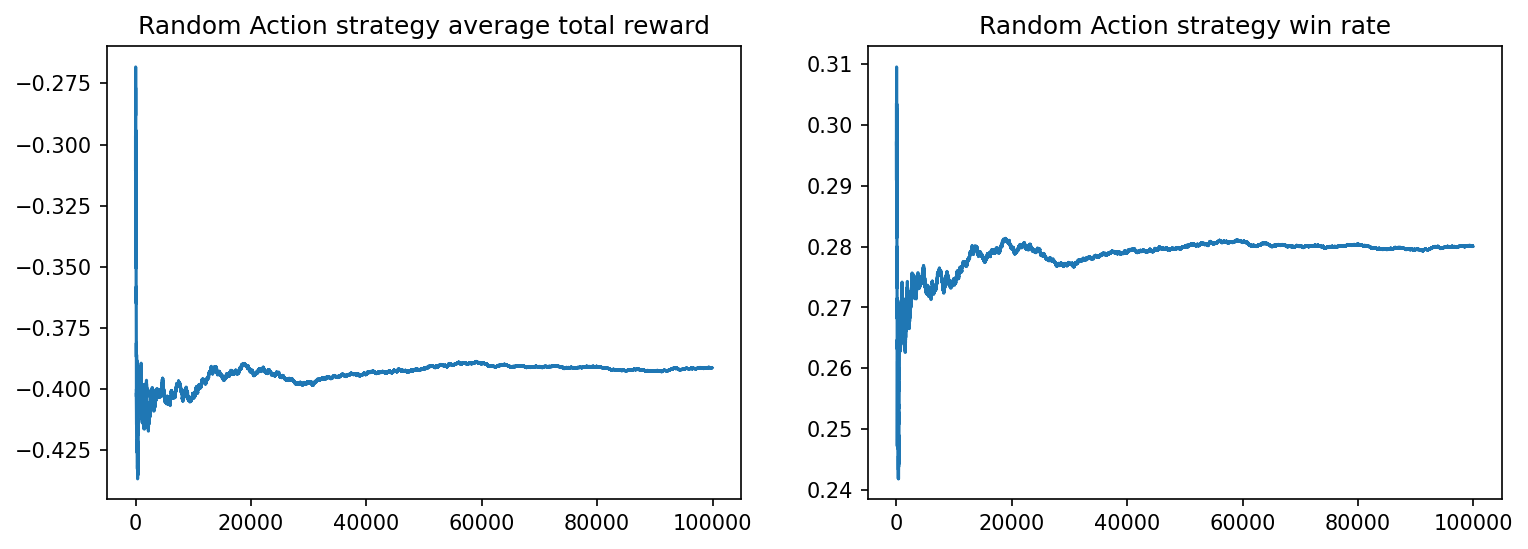

In [295]:
random_action = RandomAction(env)
black_jack = BlackjackExperiment(env, 100000, random_action)
total_reward, win_rate = black_jack.experiment()
print(f"Random Action total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Random Action")

Constant strategy total reward: -0.17095, win rate: 0.38062


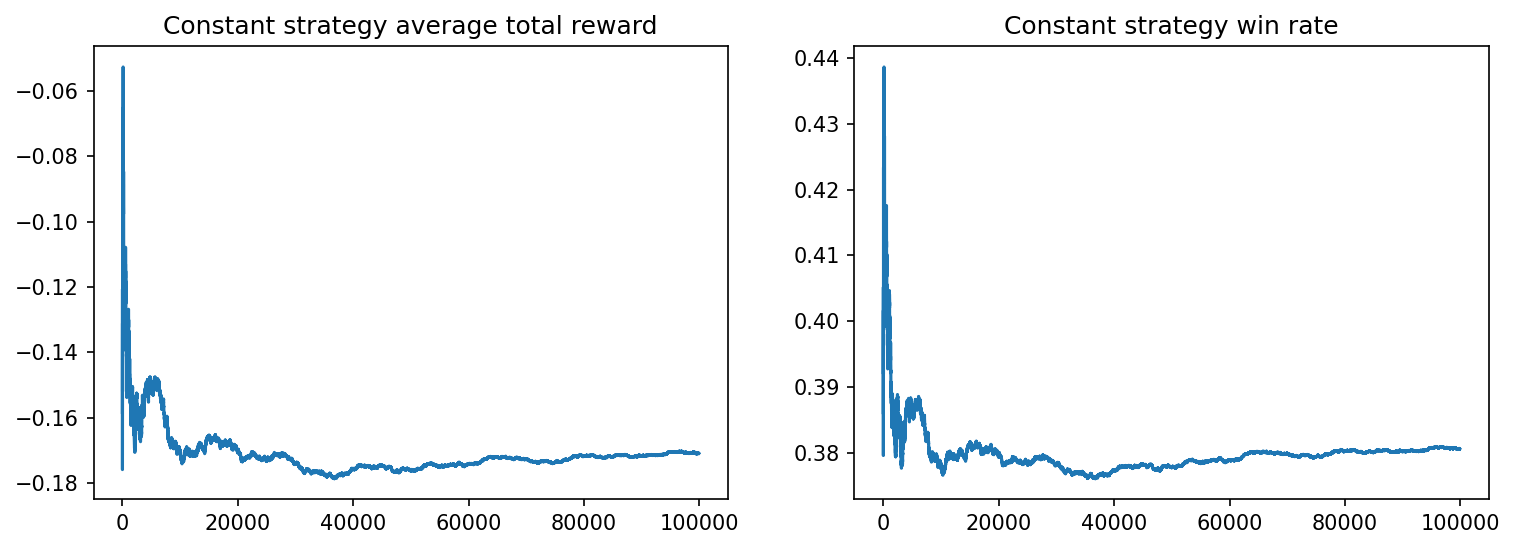

In [296]:
constant_strategy = ConstantStrategy()
black_jack = BlackjackExperiment(env, 100000, constant_strategy)
total_reward, win_rate = black_jack.experiment()
print(f"Constant strategy total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Constant")

Monte Carlo Control total reward: 0.01265, win rate: 0.45995


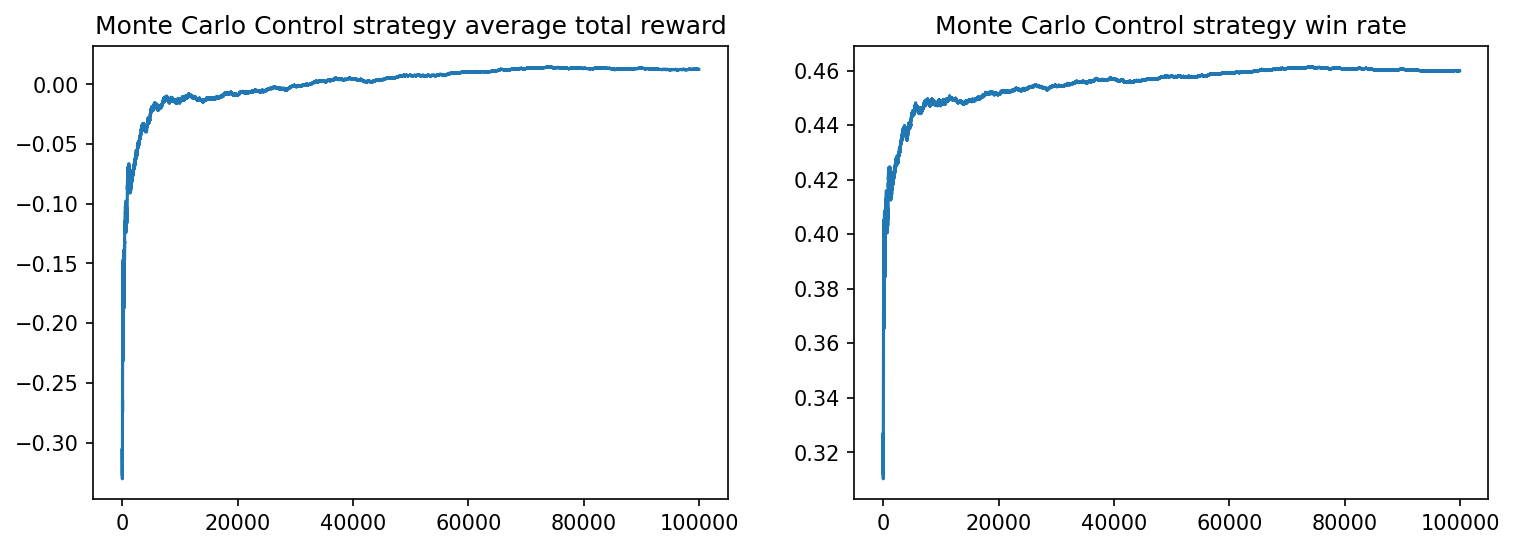

In [298]:
monte_carlo = MonteCarloControl(1, 0.8, env.action_space.n)
black_jack = BlackjackExperiment(env, 100000, monte_carlo)
total_reward, win_rate = black_jack.experiment()
print(f"Monte Carlo Control total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Monte Carlo Control")

#### Обыграли казино?:)

### Часть 2.

In [299]:
from blackjack import BlackjackDoubleEnv
env2 = BlackjackDoubleEnv()

Random Action total reward: -0.53214, win rate: 0.21579


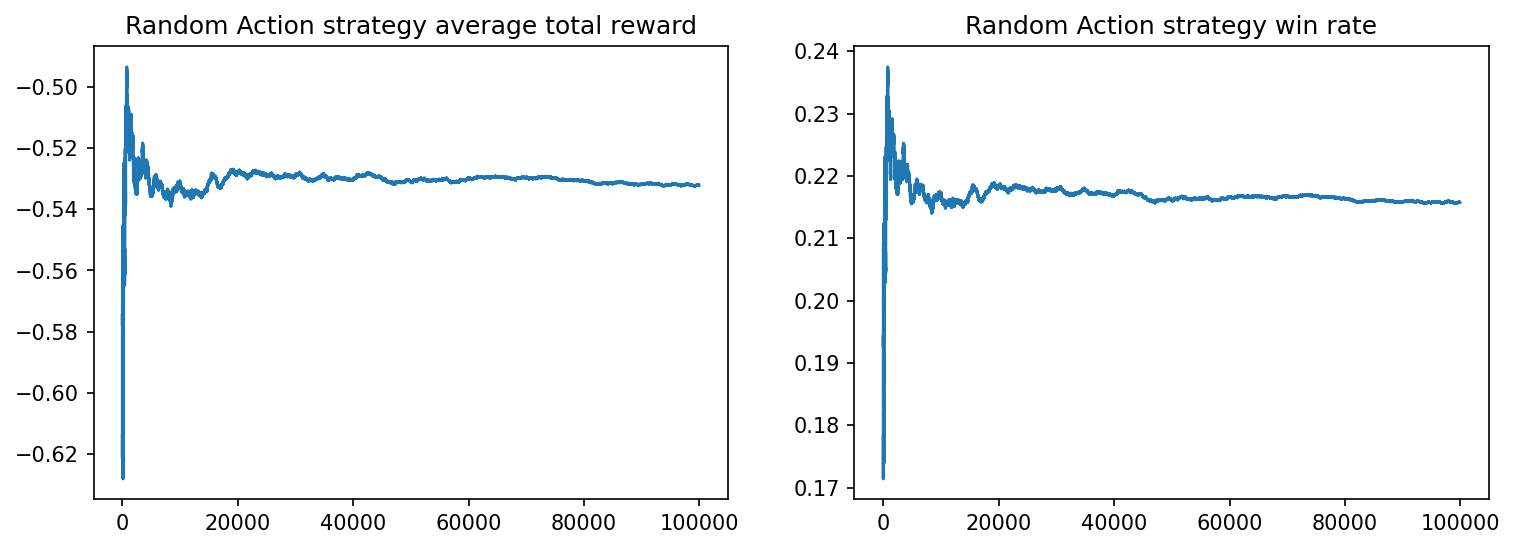

In [300]:
random_action = RandomAction(env2)
black_jack = BlackjackExperiment(env2, 100000, random_action)
total_reward, win_rate = black_jack.experiment()
print(f"Random Action total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Random Action")

Monte Carlo Control total reward: 0.00649, win rate: 0.45768


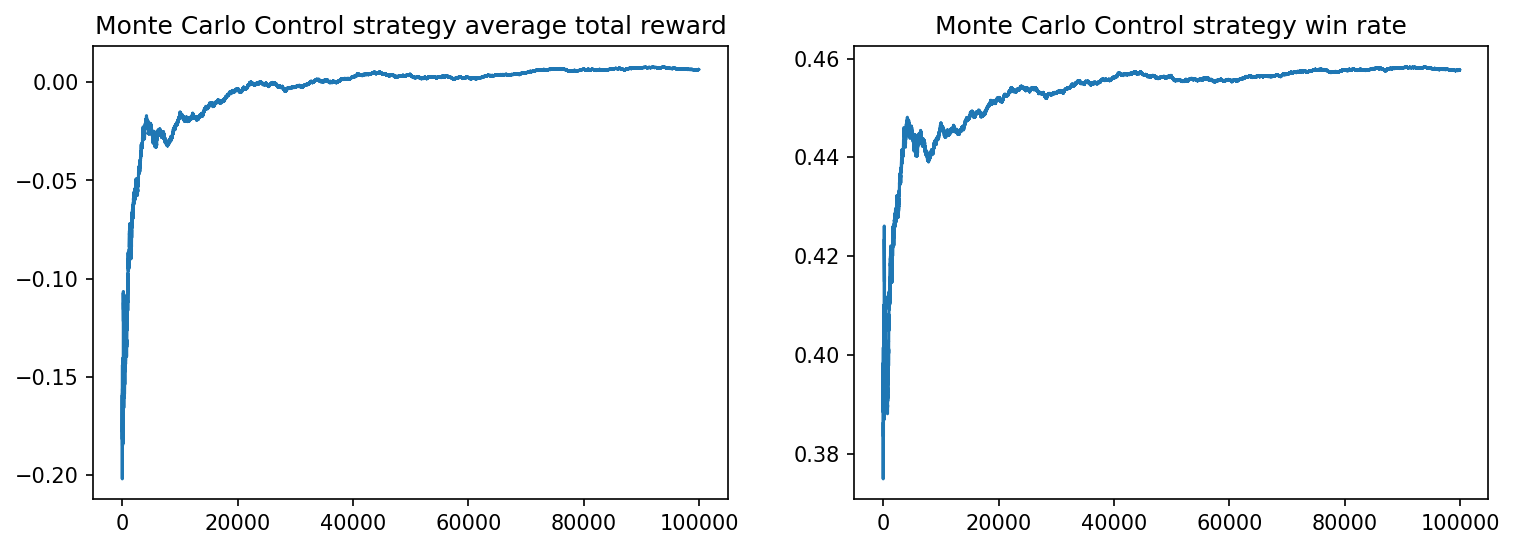

In [302]:
monte_carlo = MonteCarloControl(1, 0.82, env2.action_space.n)
black_jack = BlackjackExperiment(env2, 100000, monte_carlo)
total_reward, win_rate = black_jack.experiment()
print(f"Monte Carlo Control total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Monte Carlo Control")

#### Обыграли казино?:)

### Часть 3

In [303]:
COUNT_DICT_POLOVINKI = {
    1: -1,
    2: 0.5,
    3: 1,
    4: 1,
    5: 1.5,
    6: 1,
    7: 0.5,
    8: 0,
    9: -0.5,
    10: -1
}

In [304]:
from blackjack import BlackjackDoubleCountingEnv
env3 = BlackjackDoubleCountingEnv(COUNT_DICT_POLOVINKI)

Monte Carlo Control POLOVINKI total reward: 0.020136, win rate: 0.462058


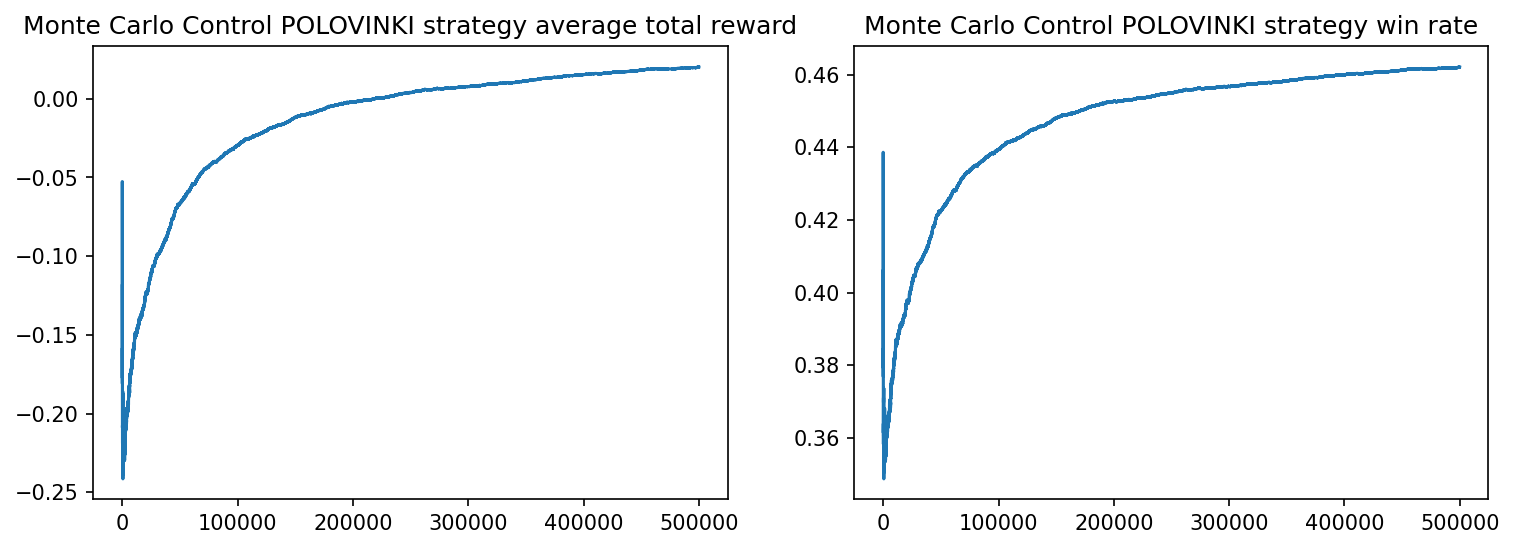

In [305]:
monte_carlo = MonteCarloControl(1, 0.95, env3.action_space.n)
black_jack = BlackjackExperiment(env3, 500000, monte_carlo)
total_reward, win_rate = black_jack.experiment()
print(f"Monte Carlo Control POLOVINKI total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Monte Carlo Control POLOVINKI")

In [306]:
COUNT_DICT_PLUS_MINUS = {
    1: -1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 0,
    8: 0,
    9: 0,
    10: -1
}

In [307]:
from blackjack import BlackjackDoubleCountingEnv
env4 = BlackjackDoubleCountingEnv(COUNT_DICT_PLUS_MINUS)

Monte Carlo Control PLUS MINUS total reward: 0.033078, win rate: 0.467834


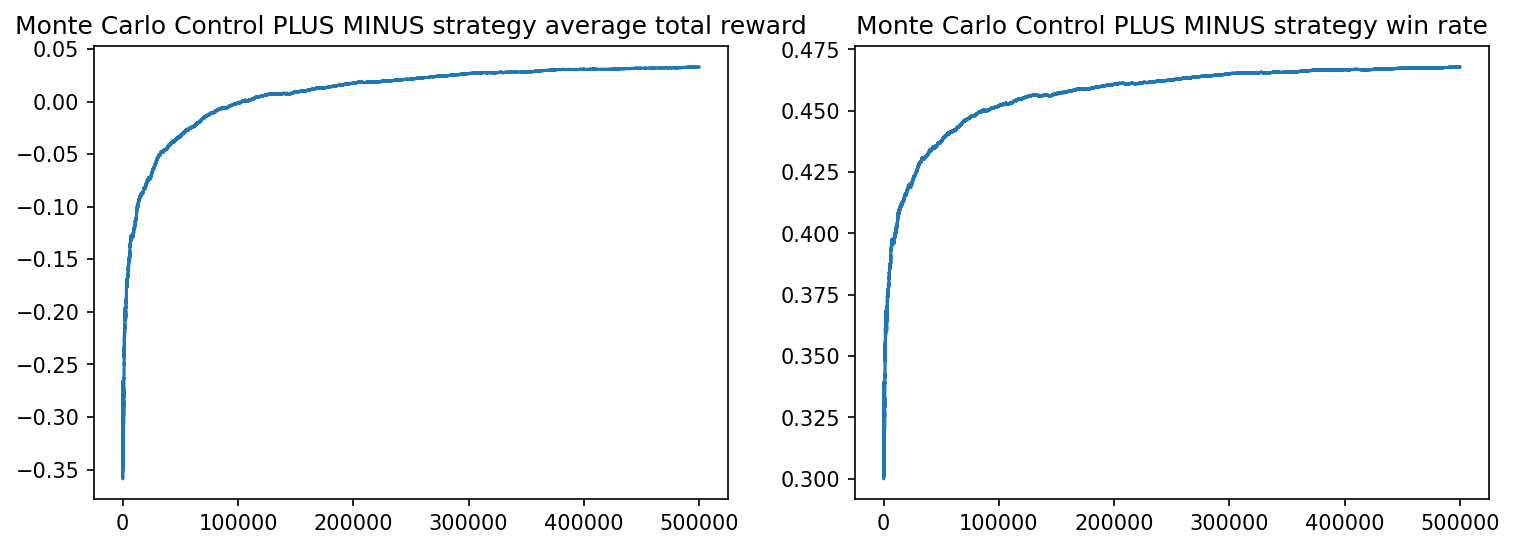

In [308]:
monte_carlo = MonteCarloControl(1, 0.9, env4.action_space.n)
black_jack = BlackjackExperiment(env4, 500000, monte_carlo)
total_reward, win_rate = black_jack.experiment()
print(f"Monte Carlo Control PLUS MINUS total reward: {total_reward[-1]}, win rate: {win_rate[-1]}")
plot(win_rate, "Monte Carlo Control PLUS MINUS")